<a href="https://www.kaggle.com/code/ayushs9020/understanding-the-competition-icr-eda?scriptVersionId=129486551" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# ICR Identify Age Related Conditions 

$ICR$, or $Identify$ $Age$ $Related$ $Conditions$, is a process aimed at `detecting and diagnosing health conditions commonly associated with aging`. It involves a `comprehensive evaluation` of an individual's `medical history`, `physical examination`, and `specific tests` to assess their overall health and `identify` any `age-related conditions`. The `goal` is to `catch potential issues early` on, allowing for `timely intervention` and `management of age-related health concerns`. $ICR$ helps healthcare professionals tailor `preventive measures` and `develop personalized` treatment plans to promote `healthy aging`.

<img src = "https://www.care.com/c/wp-content/uploads/sites/2/2021/03/getting-old-realize-meme.jpg.optimal.jpg">

# 1 | Important Points 📃
* This is a **`binary classification`** problem where $1$ is for `suffering from a disease` and $0$ is for `not suffering from any disease`.

* * The class $1$ is further divided into $3$ more categoreis, we actually do not know much about the actual names of these categories, but according to the data, these are 

* * * **B**
* * * **D**
* * * **G**

* * Though we are actually not given $1$ or $0$. Rather values like $(A , B , D , G)$

* Using $XGBoost$ and $RandomForestClassifier$ and more of such algorithms, `may give better results`, but might **not be actually benificial for the actual purpose of the competition and research**. As it is written that they have been using these algorithms from the year they were established ie $2015$. Try to come up with something different

# 2 | Advisory 🚀
## Greeks
* `Id` - It is like the primary of the data, you can probably remove that one
* `Alpha` - Change the values corresponding to `A` to $0$ , and rest to be $0$. The data is highly imbalanced, having $(0 -> 82.50)$ and $(1 -> 17.50)$. I recomend using `Random Over Sampling`.

```
from imblearn_oversampling import RandomOverSampler

features , target = RandomOverSampler().fit_resample(features , target)
```

* `Beta` - This is the first experimental characteristic, This further contains $3$ values $(A , B , C)$, but the ratio of $(A)$ is really small, At this point I have decided to assume $(A)$ as $(B)$, but we do not have any actual reason for doing so. $(A -> 1.30, B -> 32.74, C -> 67.96)$
* `Gamma` - This is the second experimental characteristic, This further contains $8$ values $(A , B , E , F , G , H , M , N)$ , but the combined ratio of $(A , B , E , F , G)$ is around $8.92$% , which is just above than their succesor $(H)$ with $8.59$%. Combining these into $1$ might give better performance. $(A ->1.30, B ->1.30, E ->1.62, F ->1.78, G ->2.92, H ->8.59, M ->10.37, N ->72.12)$. At this point I have converted these into $(G)$. There was no particular reason for converting these into $(G)$ only. 
* `Delta` - This is the third experimental characteristic. This further contains $4$ values $(A , B , C , D)$. These are in good condtion with $(A ->73.91, B ->12.16, C ->10.37, D ->3.57)$
* `Epsilon` - Though you can use this `feature` with some preprocessing, but it might not be good to classify someone with a disease on the basis of the date the person came. That is indirectly racism on date!! . 

In [1]:
import numpy as np 
import pandas as pd

In [2]:
import matplotlib.pyplot as plt 
import seaborn as sns 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from sklearn.preprocessing import StandardScaler 

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [5]:
from sklearn.metrics import classification_report 

In [6]:
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense 

In [7]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv
/kaggle/input/icr-identify-age-related-conditions/greeks.csv
/kaggle/input/icr-identify-age-related-conditions/train.csv
/kaggle/input/icr-identify-age-related-conditions/test.csv


Lets take a look at the datasets now
# 3 | Data Analysis
# 3.1 | Greeks 🔠
**Supplemental metadata, only available for the training set**.

In [8]:
greeks = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/greeks.csv")
greeks

,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020
...,...,...,...,...,...,...
612,fd3dafe738fd,A,B,M,B,9/13/2020
613,fd895603f071,A,B,M,B,9/8/2020
614,fd8ef6377f76,A,C,M,B,7/24/2019
615,fe1942975e40,A,C,M,B,1/31/2019


In [9]:
greeks.drop("Id" , axis = 1 , inplace = True)
greeks

,Alpha,Beta,Gamma,Delta,Epsilon
0,B,C,G,D,3/19/2019
1,A,C,M,B,Unknown
2,A,C,M,B,Unknown
3,A,C,M,B,Unknown
4,D,B,F,B,3/25/2020
...,...,...,...,...,...
612,A,B,M,B,9/13/2020
613,A,B,M,B,9/8/2020
614,A,C,M,B,7/24/2019
615,A,C,M,B,1/31/2019


<AxesSubplot: ylabel='Alpha'>

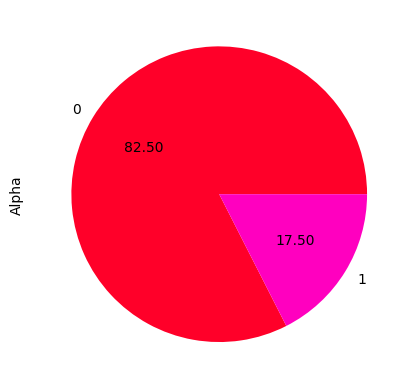

In [10]:
greeks["Alpha"] = np.where(greeks["Alpha"] == "A" , 0 , 1)
greeks["Alpha"].value_counts().plot(kind = "pie" , autopct = "%.2f" , cmap = "gist_rainbow")

<AxesSubplot: ylabel='Beta'>

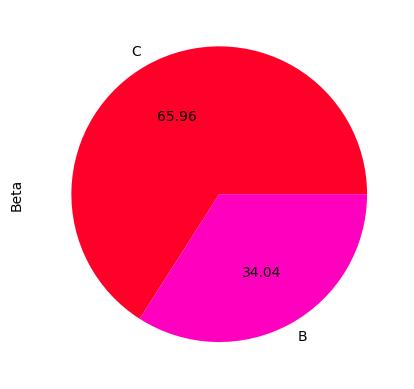

In [11]:
greeks["Beta"] = np.where(greeks["Beta"] == "A" , "B" , greeks["Beta"])
greeks["Beta"].value_counts().plot(kind = "pie" , autopct = "%.2f" , cmap = "gist_rainbow")

<AxesSubplot: ylabel='Gamma'>

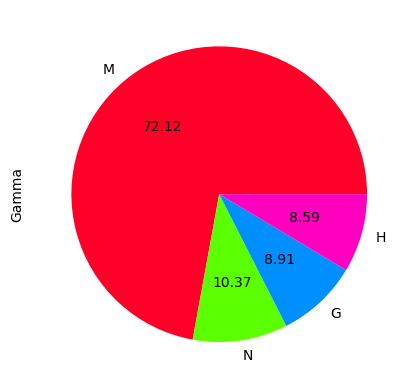

In [12]:
greeks["Gamma"] = np.where(greeks["Gamma"] == "A" , "G" , greeks["Gamma"])
greeks["Gamma"] = np.where(greeks["Gamma"] == "B" , "G" , greeks["Gamma"])
greeks["Gamma"] = np.where(greeks["Gamma"] == "E" , "G" , greeks["Gamma"])
greeks["Gamma"] = np.where(greeks["Gamma"] == "F" , "G" , greeks["Gamma"])
greeks["Gamma"].value_counts().plot(kind = "pie" , autopct = "%.2f" , cmap = "gist_rainbow")

<AxesSubplot: ylabel='Delta'>

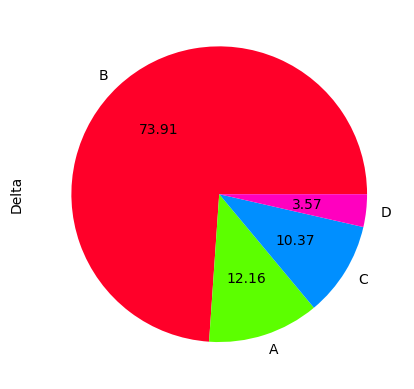

In [13]:
greeks["Delta"].value_counts().plot(kind = "pie" , autopct = "%.2f" , cmap = "gist_rainbow")

# 3.2 | Train 🚅

In [14]:
data = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/train.csv")
data

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,...,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0
613,fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,...,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0
614,fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,...,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0
615,fe1942975e40,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,...,9.256996,0.78764,0.670527,24.594488,72.611063,1965.343176,25.116750,37.155112,0.184622,0


This is how `training data` looks like. We can train different binary classification algorithm on this data. `Id` column for this data as well is just the primary key for the data, and thus can be removed. You actually dont need the `supplement metdata` for this competition in the training. As the testing data do not contain those columns. Those are just for `training data ` 

We have $617$ rows and $58$ columns accounting to $36,784$ values. This is a big data to work upon

Lets get more information about the data. 

**As there are $58$ columns, I might hide output cells in many cases to save spaces. You can still see the whole picture by clikcing on the `show output cell` button just below the code cell**

In [15]:
data.drop("Id" , axis = 1 , inplace = True)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 57 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AB      617 non-null    float64
 1   AF      617 non-null    float64
 2   AH      617 non-null    float64
 3   AM      617 non-null    float64
 4   AR      617 non-null    float64
 5   AX      617 non-null    float64
 6   AY      617 non-null    float64
 7   AZ      617 non-null    float64
 8   BC      617 non-null    float64
 9   BD      617 non-null    float64
 10  BN      617 non-null    float64
 11  BP      617 non-null    float64
 12  BQ      557 non-null    float64
 13  BR      617 non-null    float64
 14  BZ      617 non-null    float64
 15  CB      615 non-null    float64
 16  CC      614 non-null    float64
 17  CD      617 non-null    float64
 18  CF      617 non-null    float64
 19  CH      617 non-null    float64
 20  CL      617 non-null    float64
 21  CR      617 non-null    float64
 22  CS

As we can see there is a column named `EJ` which is categorical. Categorical is basically something that is in the `str` format. We cannot send `str` data into any model. So we will convert this into somekind of `numercial` data 

<AxesSubplot: ylabel='EJ'>

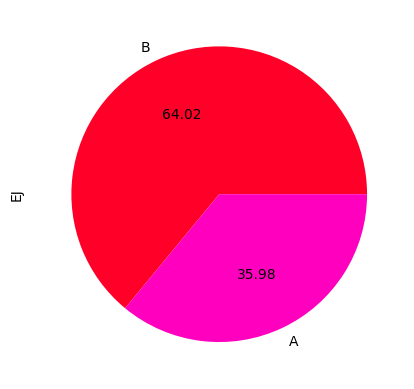

In [17]:
data["EJ"].value_counts().plot(kind = "pie" , autopct = "%.2f" , cmap = "gist_rainbow")

In [18]:
data["EJ"] = np.where(data["EJ"] == "A" , 1 , 0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 57 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AB      617 non-null    float64
 1   AF      617 non-null    float64
 2   AH      617 non-null    float64
 3   AM      617 non-null    float64
 4   AR      617 non-null    float64
 5   AX      617 non-null    float64
 6   AY      617 non-null    float64
 7   AZ      617 non-null    float64
 8   BC      617 non-null    float64
 9   BD      617 non-null    float64
 10  BN      617 non-null    float64
 11  BP      617 non-null    float64
 12  BQ      557 non-null    float64
 13  BR      617 non-null    float64
 14  BZ      617 non-null    float64
 15  CB      615 non-null    float64
 16  CC      614 non-null    float64
 17  CD      617 non-null    float64
 18  CF      617 non-null    float64
 19  CH      617 non-null    float64
 20  CL      617 non-null    float64
 21  CR      617 non-null    float64
 22  CS

Now lets check if the data has null values...

In [19]:
for feature in data.columns:
    if data[feature].isnull().any():
        print(feature , True)

BQ True
CB True
CC True
DU True
EL True
FC True
FL True
FS True
GL True


So these columns have `null/nan`, we cannot send `null` values into models. We need to change them with some values. One way is to change them with `mean values`

In [20]:
for feature in data.columns:
    if data[feature].isnull().any():
        data[feature].fillna(value = data[feature].mean() , axis = 0 , inplace = True)

In [21]:
for feature in data.columns:
    if data[feature].isnull().any():
        print(feature , True)

And now there is no null values in the data 

# 3.3 | Test 🧪

In [22]:
test = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/test.csv")
test

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


And this is our testing data. Yes it only contains $5$ rows 
# 4 | Model Building 🤖

To ensure that all features contribute equally to the model.

Features with different scales can have a disproportionate impact on the model, leading to inaccurate results. Scaling ensures that all features are on a similar scale, so that the model can learn from them equally.

Here we will be using **[sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)**, but for getting into deep how the scaler works, below is the code for you and here is the notebook containing the **[explanation](https://www.kaggle.com/code/ayushs9020/scaling-techniques-from-scratch)**

```
! pip install numpy 

import numpy as np 

def standard_scaler(array , copy = True):
    if copy:
        
        y = np.empty(shape = array.shape)
        
        for i,j in enumerate(array):
            
            y[i] = (j - array.mean()) / (array.std())
        
        return y
    
    else :
        
        for i,j in enumerate(array):
            
            array[i] = (j - array.mean()) / (array.std())
        
        return array
```

In [23]:
train , val = np.split(data.sample(frac = 1) , [int(len(data) * 0.8)])

In [24]:
def pre(dataframe):
    X = dataframe.drop("Class" , axis = 1)
    y = dataframe["Class"]
    
    return X , y

In [25]:
X_train , y_train = pre(train)
X_val , y_val = pre(val)

# 5.1 | K Nearest Neighbors 🚗

K Nearest Neighbors (KNN) is a supervised machine learning algorithm that can be used for both classification and regression problems. It works by finding the k most similar data points to a new data point and then assigning the new data point to the class of the majority of the k nearest neighbors.

<img src = "https://media.geeksforgeeks.org/wp-content/uploads/20200616145419/Untitled2781.png">

If you want to know more about `KNN` here is the code for you, and here is the notebook with the **[explanation](https://www.kaggle.com/code/ayushs9020/knn-from-scratch)**

```
! pip install collections
! pip install numpy

from collections import Counter
import numpy as np 

def KNN(X_train , y_train , X_test):
    
    distance = [0] * X_train.shape[0]
    
    for columns in X_train.columns:
        
        for index in range(len(X_train[columns])):
            
            distance[index] += X_train[columns][index] - X_test[columns][index]
    
    distance = np.sqrt(np.array(distance))
    
    return Counter(y_test[np.argsort(distance)[:3]]).most_common()[0][0]
```

<img src = "https://www.mihaileric.com/static/knn-meme-d997d3c26b3769fc03492b12819c6223-d90b6.jpg">

In [26]:
KNN = KNeighborsClassifier()
KNN.fit(X_train , y_train)

KNeighborsClassifier()

# 5.2 | Logistic Regression 

Logistic regression is a statistical model that is used to predict the probability of an event occurring. It is a type of regression analysis that uses a logistic function to model the probability of a binary outcome. The logistic function is a sigmoid function that maps real numbers to the interval $(0, 1)$. This means that the output of the logistic function can be interpreted as the probability of an event occurring.

<img src = "https://miro.medium.com/v2/resize:fit:800/1*is3vZACPepjNVWf-j6kUgA.jpeg">

In [27]:
LR = LogisticRegression()
LR.fit(X_train , y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

<img src = "https://www.mihaileric.com/static/logistic_regression_meme-dc70fd90996941296fb922886a138053-ed51e.jpg">

# 7 | Neural Networks 

eural networks are a type of machine learning algorithm inspired by the human brain. They are made up of layers of interconnected nodes, and they learn to perform tasks by adjusting the weights of the connections between these nodes. Neural networks have been used to achieve state-of-the-art results in a wide range of tasks, including image classification, natural language processing, and speech recognition.

<img src = "https://media.makeameme.org/created/neural-networks-neural.jpg">

In [28]:
NN = Sequential() 

NN.add(Dense(56 , activation = "sigmoid" , input_dim = 56))
NN.add(Dense(50 , activation = "sigmoid" , input_dim = 56))
NN.add(Dense(40 , activation = "sigmoid" , input_dim = 50))
NN.add(Dense(30 , activation = "sigmoid" , input_dim = 40))
NN.add(Dense(20 , activation = "sigmoid" , input_dim = 30))
NN.add(Dense(10 , activation = "sigmoid" , input_dim = 20))

NN.add(Dense(1 , activation = "sigmoid" , input_dim = 10))

In [29]:
NN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 56)                3192      
                                                                 
 dense_1 (Dense)             (None, 50)                2850      
                                                                 
 dense_2 (Dense)             (None, 40)                2040      
                                                                 
 dense_3 (Dense)             (None, 30)                1230      
                                                                 
 dense_4 (Dense)             (None, 20)                620       
                                                                 
 dense_5 (Dense)             (None, 10)                210       
                                                                 
 dense_6 (Dense)             (None, 1)                 1

In [30]:
NN.compile(loss = "binary_crossentropy" , optimizer = "Adam" , metrics = ["accuracy"])

In [31]:
sample_fit = NN.fit(X_train , y_train , epochs = 100 , validation_split = 0.2)

Epoch 1/100
13/13 [==============================] - 2s 31ms/step - loss: 0.4676 - accuracy: 0.8274 - val_loss: 0.4209 - val_accuracy: 0.8586
Epoch 2/100
13/13 [==============================] - 0s 6ms/step - loss: 0.4628 - accuracy: 0.8274 - val_loss: 0.4122 - val_accuracy: 0.8586
Epoch 3/100
13/13 [==============================] - 0s 6ms/step - loss: 0.4601 - accuracy: 0.8274 - val_loss: 0.4112 - val_accuracy: 0.8586
Epoch 4/100
13/13 [==============================] - 0s 6ms/step - loss: 0.4598 - accuracy: 0.8274 - val_loss: 0.4114 - val_accuracy: 0.8586
Epoch 5/100
13/13 [==============================] - 0s 7ms/step - loss: 0.4596 - accuracy: 0.8274 - val_loss: 0.4122 - val_accuracy: 0.8586
Epoch 6/100
13/13 [==============================] - 0s 7ms/step - loss: 0.4599 - accuracy: 0.8274 - val_loss: 0.4111 - val_accuracy: 0.8586
Epoch 7/100
13/13 [==============================] - 0s 6ms/step - loss: 0.4595 - accuracy: 0.8274 - val_loss: 0.4119 - val_accuracy: 0.8586
Epoch 8/100


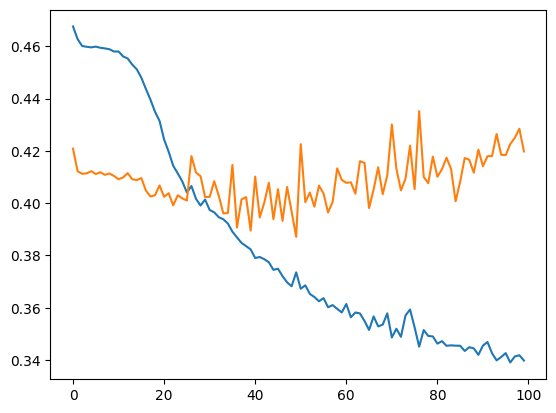

In [32]:
plt.plot(sample_fit.history["loss"])
plt.plot(sample_fit.history["val_loss"])
plt.show()

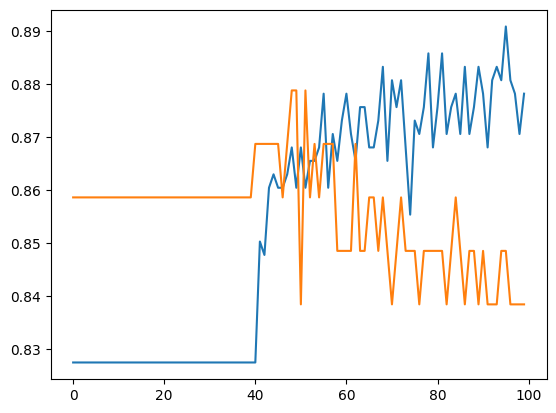

In [33]:
plt.plot(sample_fit.history["accuracy"])
plt.plot(sample_fit.history["val_accuracy"])
plt.show()

# 6 | Metrics 📈
Metrics are used to evaluate the performance of a machine learning model. They can be used to measure the accuracy, precision, recall, and other aspects of a model's performance. Metrics are an important part of the machine learning process, as they help to ensure that models are performing as expected.

In [34]:
print(KNN , classification_report(y_val , KNN.predict(X_val)))
print(LR , classification_report(y_val , LR.predict(X_val)))

print(NN , "Score = " , NN.evaluate(X_val, y_val, verbose = 0)[1] * 100)

KNeighborsClassifier()               precision    recall  f1-score   support

           0       0.79      0.95      0.87        98
           1       0.29      0.08      0.12        26

    accuracy                           0.77       124
   macro avg       0.54      0.51      0.49       124
weighted avg       0.69      0.77      0.71       124

LogisticRegression()               precision    recall  f1-score   support

           0       0.81      0.94      0.87        98
           1       0.40      0.15      0.22        26

    accuracy                           0.77       124
   macro avg       0.60      0.55      0.55       124
weighted avg       0.72      0.77      0.73       124

<keras.engine.sequential.Sequential object at 0x7d23ab104dc0> Score =  75.0


As we can see we got $85$% accuracy with this morel. We will try to improve this accuracy with many concepts and techniques in further version 

# 7 | TO DO LIST 📄

```
# TO DO 6 - REDUCE THE TRAINING TIME

# TO DO 7 - IMPROVE THE SCORE

# TO DO 8 - DANCE !!!!
```

**THAT IT FOR TODAY GUYS**

**WE WILL GO DEEPER INTO THE DATA IN THE UPCOMING VERSIONS**

**PLEASE COMMENT YOUR THOUGHTS, HIHGLY APPRICIATED**

**DONT FORGET TO MAKE AN UPVOTE, IF YOU LIKED MY WORK :)**

<img src = "https://i.imgflip.com/19aadg.jpg">

**PEACE OUT !!!! :)**